# Feature Engineering

## Add Centrality Score

In [3]:
import networkx as nx
import pandas as pd

account_df = pd.read_csv('data/processed/kaggle_transaction_dataset.csv')
address_mapping = pd.DataFrame(data={
    'address': account_df['address'], 
    'mapped_id': account_df['address'].index
})

transaction_df = pd.read_csv('data/queried/full_transactions.csv')
transaction_mapping = transaction_df \
    .merge(
        address_mapping, 
        left_on='address from', 
        right_on='address'
    ) \
    .merge(
        address_mapping, 
        left_on='address to', 
        right_on='address', 
        suffixes=('_from', '_to')
    )[['mapped_id_from', 'mapped_id_to']]
    
G = nx.Graph()
for address in address_mapping['mapped_id']:
    G.add_node(address)
for _, row in transaction_mapping.iterrows():
    G.add_edge(row['mapped_id_from'], row['mapped_id_to'])
    
account_df['degree_centrality'] = nx.degree_centrality(G)
account_df['betweeness_centrality'] = nx.betweenness_centrality(G, k=5000)
account_df['eigenvector_centrality'] = nx.eigenvector_centrality_numpy(G)

account_df.to_csv('data/processed/kaggle_transaction_dataset_centrality.csv', index=False)

# Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('data/processed/kaggle_transaction_dataset_centrality.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20302 entries, 0 to 20301
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   address                  20302 non-null  object 
 1   flag                     20302 non-null  int64  
 2   avgTimeBetweenSentTnx    20302 non-null  float64
 3   avgTimeBetweenRecTnx     20302 non-null  float64
 4   lifetime                 20302 non-null  float64
 5   sentTransactions         20302 non-null  int64  
 6   receivedTransactions     20302 non-null  int64  
 7   createdContracts         20302 non-null  int64  
 8   numUniqRecAddress        20302 non-null  int64  
 9   numUniqSentAddress       20302 non-null  int64  
 10  minValReceived           20302 non-null  float64
 11  maxValReceived           20302 non-null  float64
 12  avgValReceived           20302 non-null  float64
 13  minValSent               20302 non-null  float64
 14  maxValSent            

## Distribution of Flag

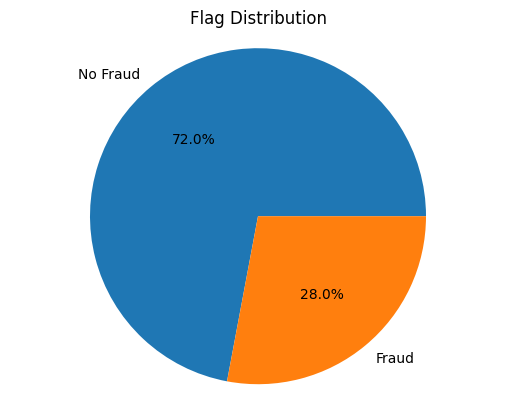

In [6]:
plt.pie(
    df['flag'].value_counts(), 
    labels=['No Fraud', 'Fraud'], 
    autopct='%1.1f%%'
)
plt.axis('equal')
plt.title('Flag Distribution')
plt.show()

## Correlation of features

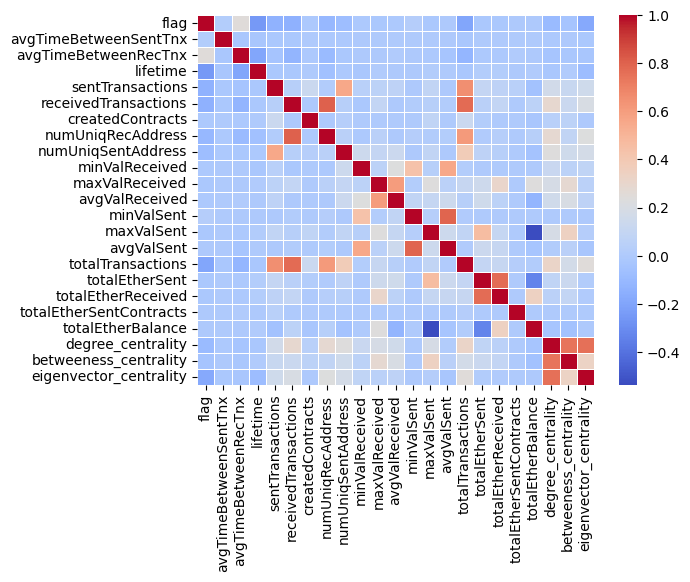

In [23]:
correlation_matrix = df.drop(columns='address').corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.show()

In [24]:
df_num_corr = correlation_matrix['flag'][1:] 
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with FLAG:\n{}".format(len(golden_features_list), golden_features_list))

There is 0 strongly correlated values with FLAG:
Series([], Name: flag, dtype: float64)


## Distribution of features

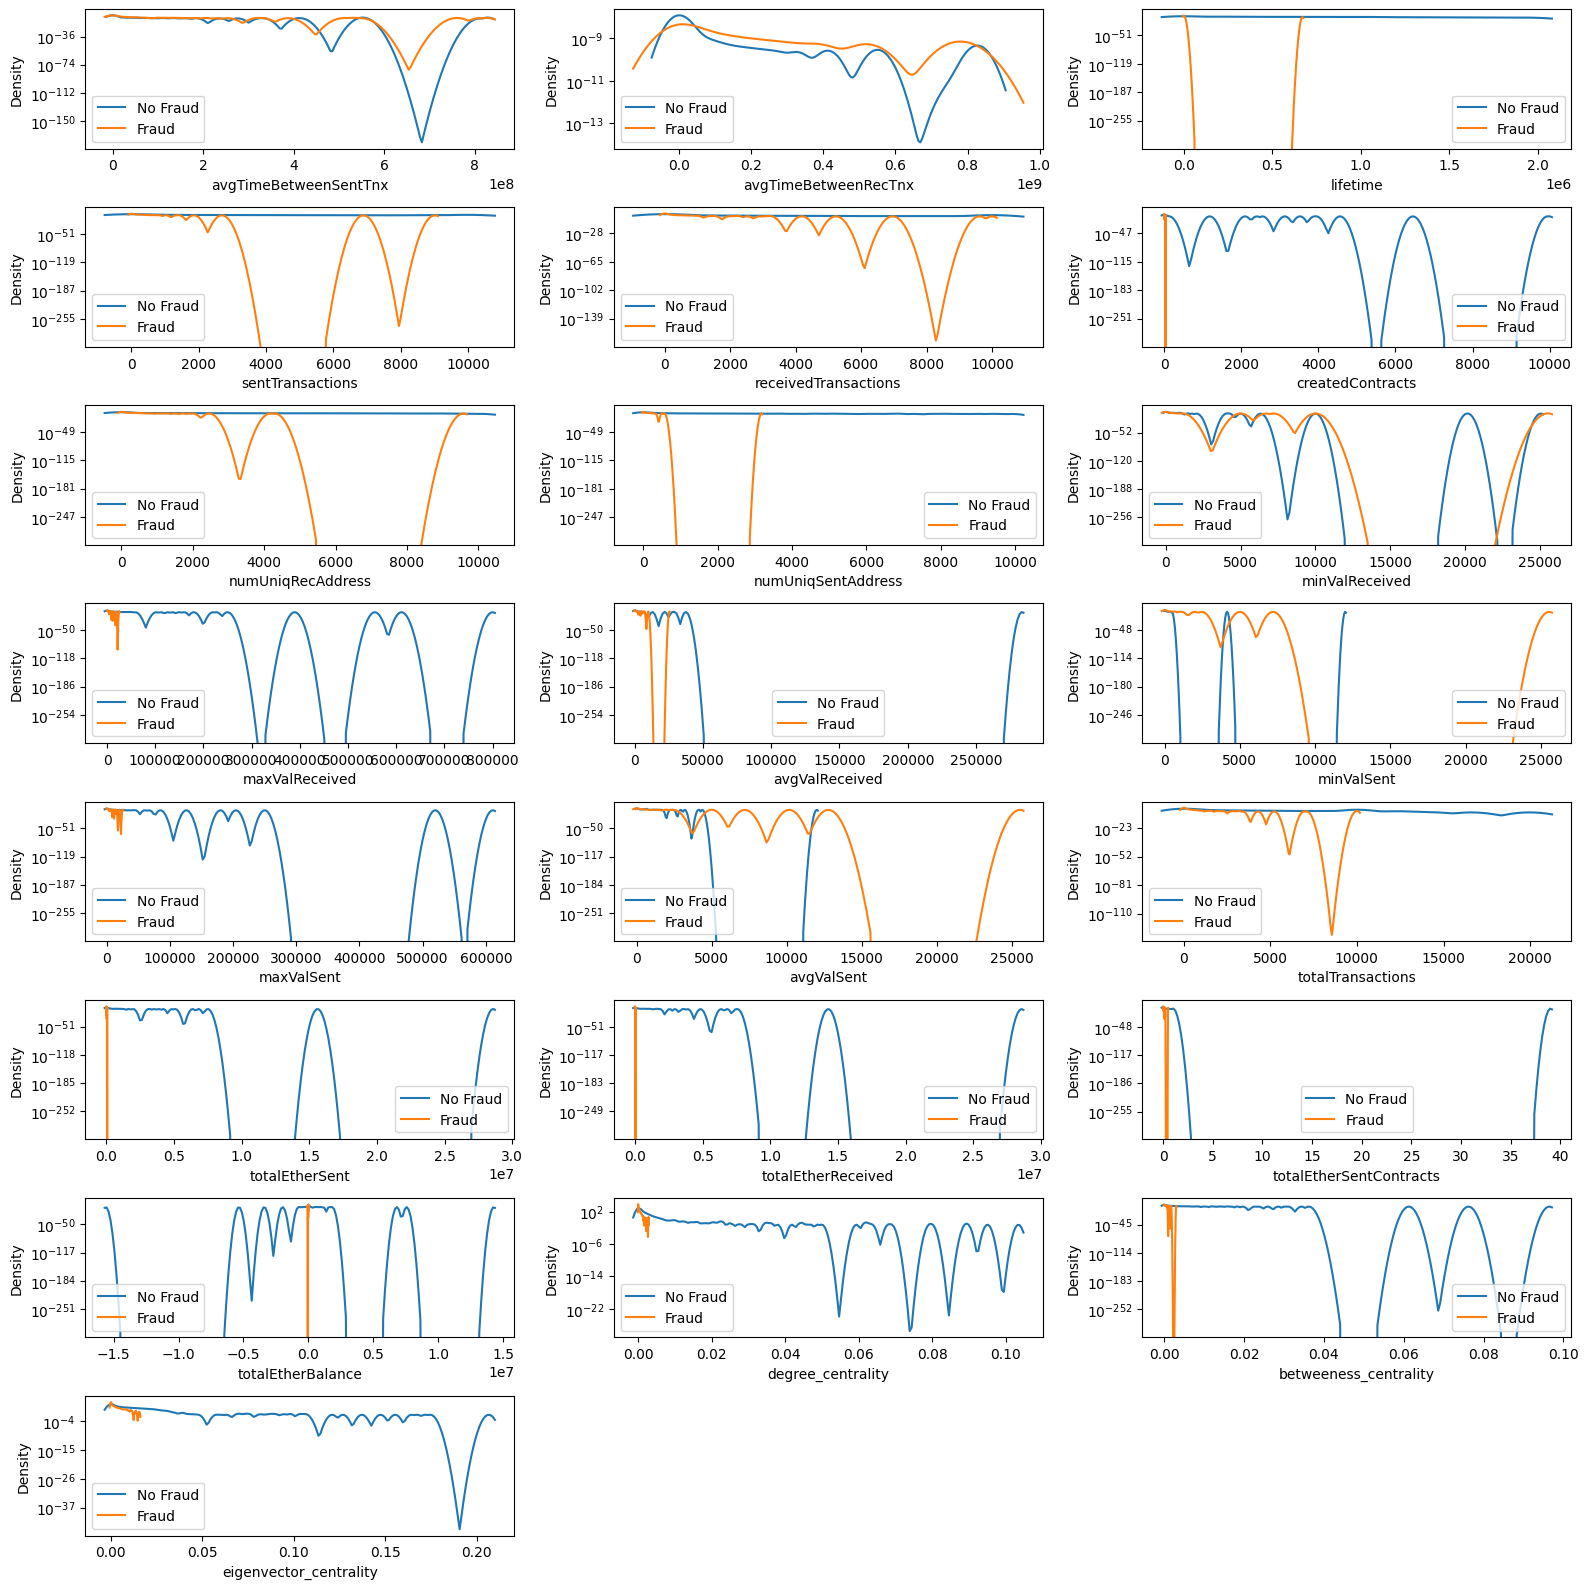

In [25]:
feature_columns = df.drop(columns=['address', 'flag']).columns

plt.figure(figsize=(16, 16))

for i, feature in enumerate(feature_columns):
    plt.subplot(8, len(feature_columns) // 8 + 1, i + 1)
    sns.kdeplot(x=feature, data=df[df['flag'] == 0], label='No Fraud')
    sns.kdeplot(x=feature, data=df[df['flag'] == 1], label='Fraud')
    plt.yscale('log')
    plt.legend()

plt.tight_layout()
plt.show()

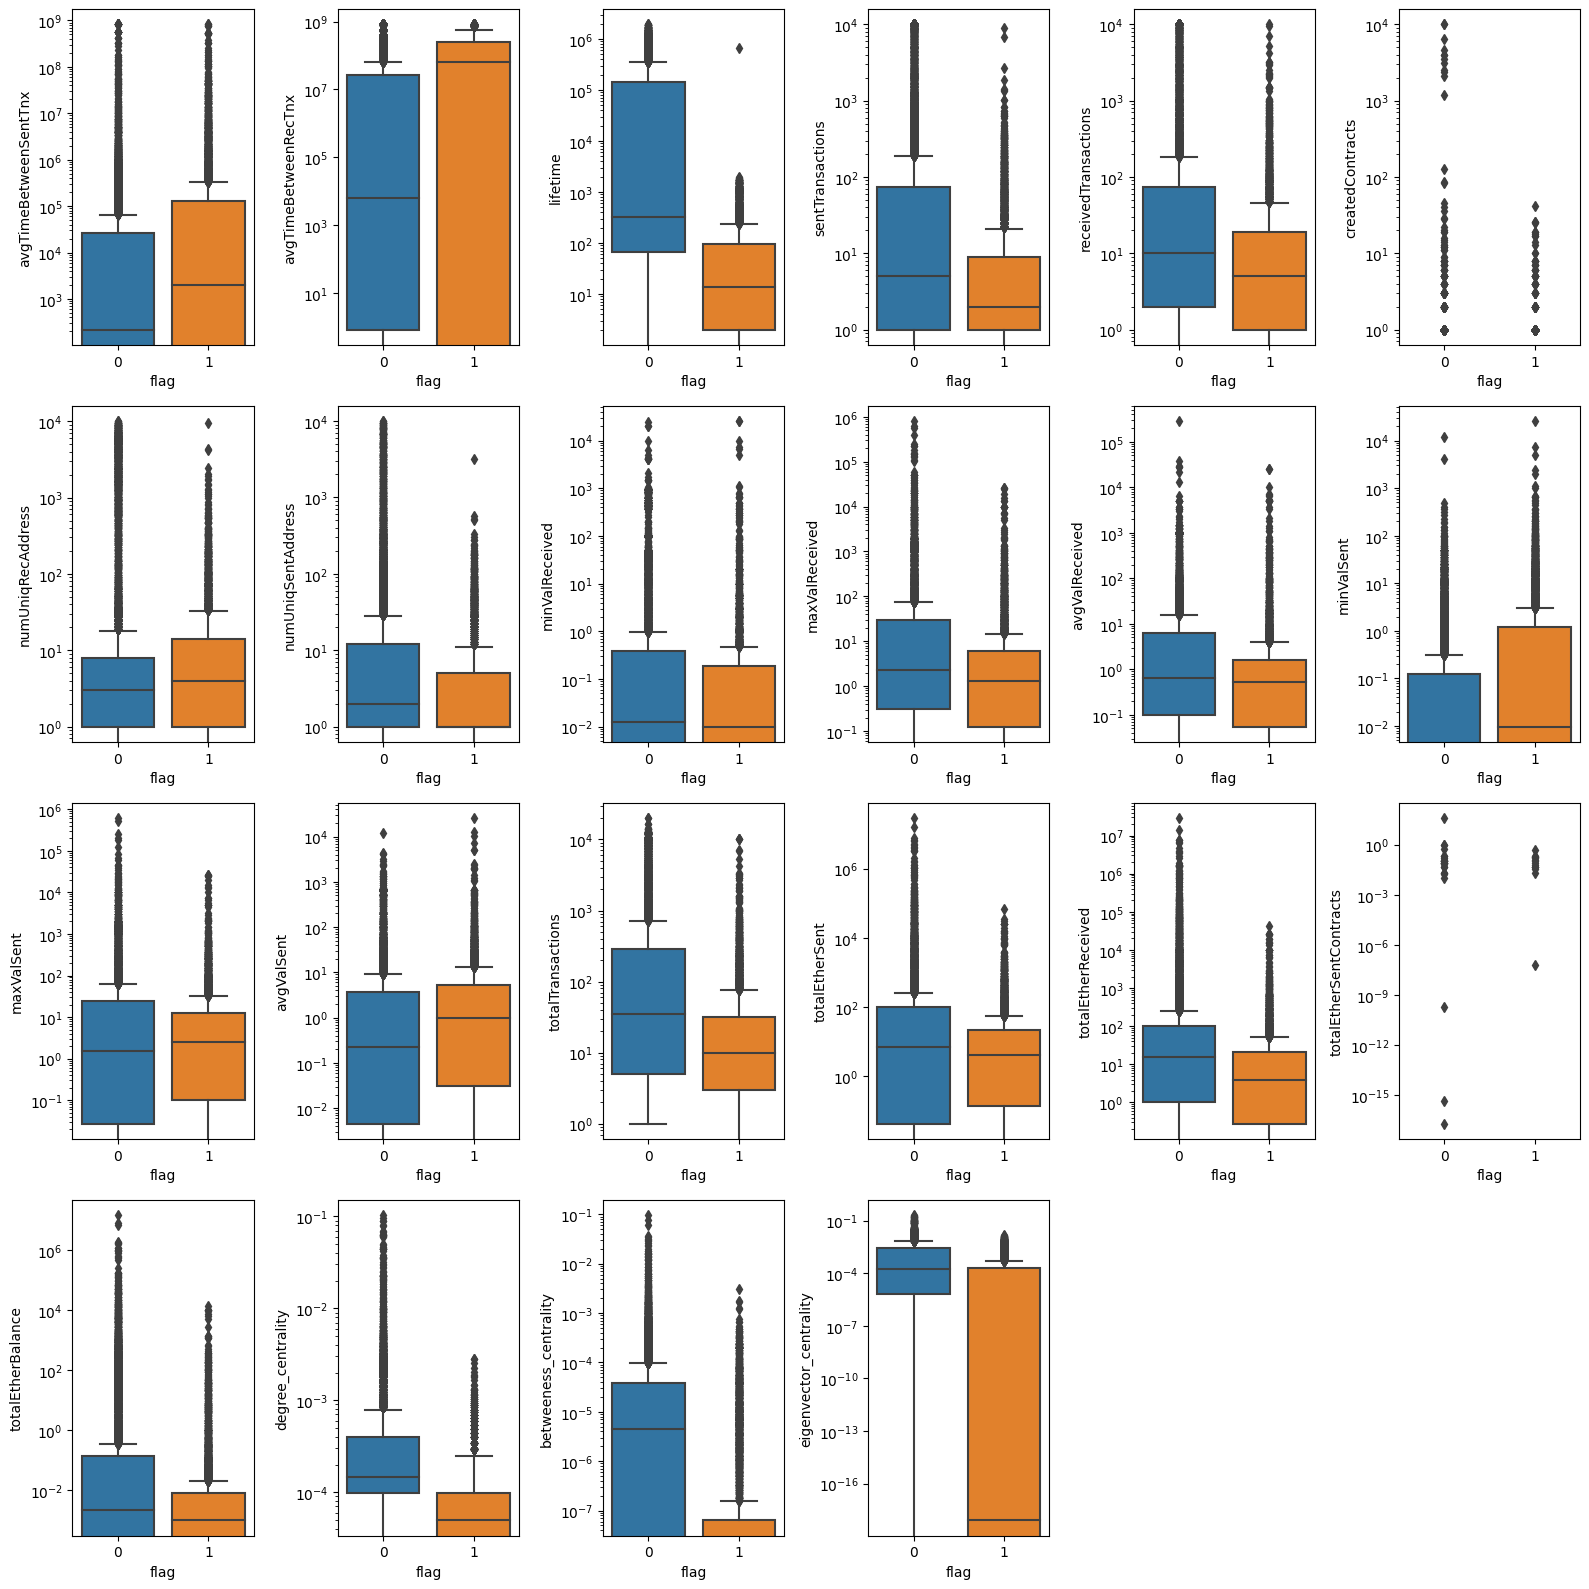

In [15]:
feature_columns = df.drop(columns=['address', 'flag']).columns

plt.figure(figsize=(16, 16))

for i, feature in enumerate(feature_columns):
    plt.subplot(4, len(feature_columns) // 4 + 1, i + 1)
    sns.boxplot(x='flag', y=feature, data=df)
    plt.yscale('log')

plt.tight_layout()
plt.show()